In [1]:
import pdb

In [15]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [16]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) 

1.0
0.0


In [17]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 28, 28)
(12000, 28, 28)


In [12]:
print(y_train.shape)

(48000, 10)


In [88]:
class Scratch2dCNNClassifier:
    def __init__(self, filters, kernel_size, padding, strides, pooling_size=(2,2), lr=0.01, n_iter=1, sigma=0.01, verbose = True):
        self.verbose = verbose
        self.lr = lr
        self.iter = n_iter
        self.strides = strides
        self.padding = padding
        self.filters = filters
        self.kernel_size = kernel_size
        self.pooling_size = pooling_size
        self.batch_size = 20
        self.sigma = sigma
        self.cost_list = []
        self.cost_list_tr = []
        self.cost_list_val = []
        self.optimizer = None
        self.X = None

        
    def fit(self, X, y):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
    # このfor文内でミニバッチが使える
        #インスタンス作成
        self.X = np.array(X)
        
        optimizer = SGD(self.lr)
        node1 = int(((X.shape[3] + 2*self.padding - self.kernel_size[0]) / self.strides + 1) / self.pooling_size[0]) * \
                int(((self.X.shape[4] + 2*self.padding - self.kernel_size[1]) / self.strides + 1) / self.pooling_size[1]) * self.filters
        
        self.SC = SimpleConv2d(self.kernel_size, self.padding, self.strides, SimpleInitializer(self.X.shape[2], self.kernel_size, self.filters, self.sigma), self.lr)
        self.activation1 = Relu()
        self.MP = MaxPool2D(self.pooling_size)
        self.FC = FC(node1, 10, FCInitializer(self.sigma), optimizer)
        self.FL = Flatten()
        self.activation2 = Softmax()
        
        batch_n = X.shape[0] // self.batch_size
        for ite in range(self.iter):
            s = 0
            for i in range(batch_n):
                X_batch = X[s:s+self.batch_size, :, :, :, :]
                y_batch = y[s:s+self.batch_size, :]
    
                self.forward(X_batch)
                self.backward(X_batch, y_batch)
                s = s + self.batch_size
            self.cost_list_tr.append(np.mean(self.cost_list)/self.batch_size)
            self.cost_list = []
            
            if self.verbose:
                print(ite)
                

    def forward(self, X):
        # フォワード
        output = self.SC.forward(X)
        output = self.activation1.forward(output)
        output = self.MP.forward(output)
        output = self.FL.forward(output)
        node1 = len(output)
        self.Z = output
        output = self.FC.forward(self.Z)
        self.pred = self.activation2.forward(output)
        
        return self.pred

    def backward(self, X, y):
        # バックワード
        dout = self.activation2.backward(self.pred, y)
        cost = self.activation2.cost(self.pred, y, 1)
        self.cost_list.append(cost)
        dout = self.FC.backward(dout, self.Z)
        dout = self.FL.backward(dout)
        dout = self.MP.backward(dout)            
        dout = self.activation1.backward(dout)
        self.SC.backward(dout, X)

            
            
                
#         if self.verbose:
#             print("{}回目".format(ite+1))
            
                 


        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pred = self.forward(X)
        pred = np.argmax(pred, axis=1)
        return pred

In [4]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.b = initializer.B(self.n_nodes2)
        self.dA = None
        self.Z = None
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """  
        A = np.dot(X, self.W) + self.b
        return A
    
    def backward(self, dA, Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        self.dA = dA
        self.Z = Z
        dZ = np.dot(self.dA, self.W.T)
        self = self.optimizer.update(self)
        return dZ

In [81]:
class Flatten:
    def __init__(self,):
        self.a = None
        self.b = None
        self.c = None
        self.d = None
        self.e = None
        
    def forward(self, X):
        (self.a, self.b, self.c, self.d, self.e) = X.shape
        X = np.reshape(X, [self.a, -1])
        return X
    
    def backward(self, dout):
        dout = np.reshape(dout, [self.a, self.b, self.c, self.d, self.e])
        return dout

In [45]:
class MaxPool2D:
    def __init__(self, pooling_size):
        self.pooling_size = np.array(pooling_size)
    
    def forward(self, X):
        height = self.pooling_size[0]
        width = self.pooling_size[1]
        self.h = X.shape[3] // height
        self.w = X.shape[4] // width

        pool_h = 0
        pool_w = 0
        
        copy = X
        pooling_X = np.zeros([X.shape[0], X.shape[1], X.shape[2], self.h, self.w])
        self.back_pool = np.zeros(X.shape)
        for i in range(self.h):
            for j in range(self.w):
                for k in range(X.shape[1]):
                    for sample in range(X.shape[0]):
                        max_index = np.argmax(X[sample, k, :, pool_h:pool_h+height, pool_w:pool_w+width])
                        max_height = max_index // width
                        max_width = max_index % width
                        self.back_pool[sample, k, pool_h:pool_h+max_height, pool_w:pool_w+max_width] = 1 
                        pooling_X[sample, k, :, i, j] = np.max(X[sample, k, :, pool_h:pool_h+height, pool_w:pool_w+width])
                pool_w += width
            pool_w = 0
            pool_h += height
        
        return pooling_X
    
    def backward(self, dout):
        back_dout = np.zeros(self.back_pool.shape)
        pool_h = 0
        pool_w = 0
        for i in range(self.h):
            for j in range(self.w):
                for k in range(self.back_pool.shape[1]):
                    for sample in range(self.back_pool.shape[0]):
                        back_dout[sample, k, :, pool_h:pool_h+self.pooling_size[0], pool_w:pool_w+self.pooling_size[1]] = dout[sample, k, :, i, j]
                pool_w += self.pooling_size[1]
            pool_w = 0
            pool_h += self.pooling_size[0]
        dout = back_dout * self.back_pool
        return dout
        
        

In [71]:
# X_size = (n_samples, filters, n_channels, height, width)
# W_size = (n_filters, n_kernels, height, width)
# b_size = (n_channel, height)
class SimpleConv2d:
    def __init__(self, kernel_size, padding, strides, initializer, lr):
        self.W = initializer.W()
        self.b = initializer.B()
        self.strides = strides
        self.padding = padding
        self.kernel_size = np.array(kernel_size)
        self.lr = lr
        self.X = None
        self.dZ = None
    
    # 出力サイズを求める。
    def output_size(self,X):
        # 縦
        self.next_feature_num_h = int((self.X.shape[3] + 2*self.padding - self.W.shape[2]) / self.strides + 1)
        
        # 横
        self.next_feature_num_w = int((self.X.shape[4] + 2*self.padding - self.W.shape[3]) / self.strides + 1)
    
    # パディング(あとで)
#     def padding_app(self, X):
#         for i in range(self.padding):
#             zero_h = np.array([0])
#             X = np.insert(X, 0, zero_h, axis=1)
#             X = np.insert(X, X.shape[3], zero_h, axis=1)

#             zero_w = np.array([0])
#             X = np.insert(X, 0, zero_w, axis=0)
#             X = np.insert(X, X.shape[3], zero_h, axis=1)
            
    
    def forward(self, X):
        self.X = X
        self.output_size(self.X)
        #パディング
#         for i in range(self.padding):
#             zero_h = np.array([0])
#             self.X = np.insert(self.X, 0, zero_h, axis=1)
#             self.X = np.insert(self.X, self.X.shape[1], zero_h, axis=1)
       
        # 積和後のフォーマットを作成
        self.sum_of_product = np.zeros([self.X.shape[0], self.W.shape[0], self.W.shape[1], int(self.next_feature_num_h), int(self.next_feature_num_w)])

        # 積和計算
        # 縦移動
        for i in range(self.next_feature_num_h):
            # 横移動
            for j in range(self.next_feature_num_w):
                X_kernel_size = X[:, :, :, i:i+self.kernel_size[0], j:j+self.kernel_size[1]]
                calc = np.sum(np.sum(X_kernel_size * self.W, axis=4), axis=3)
                self.sum_of_product[:, :, :, i, j] += calc
        # チャネル方向へSUM
        self.conv_output = np.sum(self.sum_of_product, axis=2, keepdims=True)

        return self.conv_output

    
    def backward(self,dA, X):
        
        # Bの更新
        dB = np.sum(np.sum(np.sum(dA, axis=4), axis=3), axis=0)
        self.b -= self.lr * dB
        
        #Zの更新
        move_h = 0
        move_w = 0
        self.dx = np.zeros([self.X.shape[0], self.W.shape[0], X.shape[2], X.shape[3], X.shape[4]])
        for i in range(self.next_feature_num_h):
            # 横移動
            for j in range(self.next_feature_num_w):
                
                self.dx[:, :, :, i:i+self.kernel_size[0], j:j+self.kernel_size[1]] = self.W * np.reshape(dA[:, :, :, i, j], [self.X.shape[0], self.W.shape[0], 1, 1, 1])

        
        #Wの更新
        move_h = 0
        move_w = 0
        for i in range(self.next_feature_num_h):
            # 横移動
            for j in range(self.next_feature_num_w):
                X_kernel_size = X[:, :, :, i:i+self.kernel_size[0], j:j+self.kernel_size[1]]
                dW = X_kernel_size * np.reshape(dA[:, :, :, i, j], [self.X.shape[0],self.W.shape[0], 1, 1, 1])
                dW = np.sum(dW, axis=0) / X.shape[0]
                self.W -= self.lr * dW
        return self.dx

In [39]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, ):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dB = np.sum(np.sum(layer.dA, axis=0), axis=0, keepdims=True)
        dW = np.dot(layer.Z.T, layer.dA)
        layer.b -= self.lr*dB
        layer.W -= self.lr*dW          

In [9]:
class SimpleInitializer:
    def __init__(self, channel, kernel_size, filters, sigma):
        self.channel = channel
        self.kernel_size = kernel_size
        self.filters = filters
        self.sigma = sigma
        
    def W(self,):
        W = self.sigma * np.random.randn(self.filters, self.channel, self.kernel_size[0], self.kernel_size[1])
        return W

    def B(self,):
        B = self.sigma * np.random.randn(self.filters, 1)
        return B

In [10]:
class FCInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2, 1).T
        return B

In [11]:
class Relu:       
    def __init__(self,):
        self.mask = None
        
    def forward(self, x):
        self.mask = x > 0
        out = x * self.mask
        return out
    
    def backward(self, dout):
        dx = dout * self.mask
        return dx

In [36]:
class Softmax:
    def forward(self, y):
        return np.exp(y) / np.sum(np.exp(y), axis=1).reshape(-1, 1)
    
    def backward(self, output, y):
        dA3 = output - y
        return dA3
    
    def cost(self, output, y, batch_size):
        return -(1/batch_size)*np.sum(np.log(output)*y)

In [19]:
# [samples, filter, channel, height, width]
X_train = np.reshape(X_train, [48000, 1, 1, 28, 28])

In [20]:
X_val = np.reshape(X_val, [12000, 1, 1, 28, 28])

In [32]:
y_train = np.reshape(y_train, [48000, 10])

In [33]:
y_val = np.reshape(y_val, [12000, 10])

In [92]:
cnn = Scratch2dCNNClassifier(filters=4, kernel_size=(3, 3), padding=0, strides=1, lr=0.01, n_iter=20, sigma=0.01, verbose = True)

In [93]:
cnn.fit(X_train[:10000], y_train[:10000])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [109]:
cnn.forward(X_train[:10000])

In [111]:
print("Accuracy_Train:{:.3f}".format(np.sum(np.argmax(cnn.pred, axis=1)==np.argmax(y_train[:10000], axis=1))/len(y_train[:10000])))

Accuracy_Train:0.913


In [113]:
cnn.forward(X_val[:3000])

In [114]:
print("Accuracy_validation:{:.3f}".format(np.sum(np.argmax(cnn.pred, axis=1)==np.argmax(y_val[:3000], axis=1))/len(y_val[:3000])))

Accuracy_validation:0.901


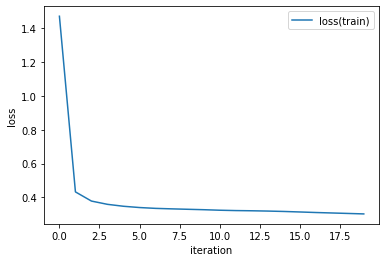

In [118]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(cnn.cost_list_tr))], cnn.cost_list_tr, label='loss(train)')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [119]:
print("畳み込み層の重み：\n",cnn.SC.W)

畳み込み層の重み：
 [[[[ 0.04918302  0.03665649  0.02623407]
   [ 0.01281163  0.01608207  0.00620309]
   [-0.00098826  0.00091231 -0.00359006]]]


 [[[ 0.33846414  0.2146589   0.10761432]
   [ 0.14360324  0.06254369  0.01799407]
   [-0.0310883  -0.02767743  0.00321822]]]


 [[[-0.00183904  0.01511391  0.0119355 ]
   [ 0.01755914  0.02151329  0.01680403]
   [ 0.05259654  0.03112382 -0.00902162]]]


 [[[ 0.18641689  0.12077781  0.0829837 ]
   [ 0.08187798  0.04081077  0.02523677]
   [-0.0072798  -0.00491183 -0.00984783]]]]


In [120]:
print("畳み込み層バイアス：\n",cnn.SC.b)

畳み込み層バイアス：
 [[0.65289533]
 [2.91594625]
 [0.70687342]
 [1.95661801]]


【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.
入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

2.
入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3.
入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

1.　出力サイズ：１４２×１４２×６　パラメータ：３×３×３×６＋６=168


2.　出力サイズ：５８×５８×４８　パラメータ：３×３×24×48＋48=10416

3.　出力サイズ：８×８×２０　パラメータ：３×３×１０×２０＋２０=1820

In [3]:
3*3*10*20+20

1820